In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from preprocessing import preprocess
from metrics import plot_confusion_matrix
from models import ngram_vectorize, vectorize
from tqdm import tqdm
from math import ceil
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from joblib import load, dump
import seaborn as sns
import matplotlib.pyplot as plt

2023-10-18 17:42:49.112963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 17:42:49.159129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 17:42:50.275980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
drive_path = Path("/run/user/1000/gvfs/google-drive:host=gmail.com,user=przemek.7678/0ACbMJp-uzuEwUk9PVA/1z7kfn_M6wSuIPxoQ_MoS2NlJgVRqyYyC")
files_path = Path("/home/hombre/Code/Climate Project/Classification/files")
source_dict = {
    "rzepa": "Rzeczypospolita",
    'gpc': "Gazeta Polska Codziennie",
    'newsweek': "Newsweek",
    'wprost' : 'Wprost',
    'dorzeczy': "DoRzeczy",
    'polityka': "Polityka",
    'wyborcza': "Gazeta Wyborcza",
    "wpolityce": "wPolityce"
}
METAFEATURES = ['Całkowita ilość słów', 'Ilość słów bez powtórzeń', 'Ilość stop-słów', 'Średnia długość słowa',
                'Ilość symboli', 'Ilość znaków interpunkcyjnych']

In [4]:
corpus = "wpolityce"
load_model = False

# Preprocessing

In [5]:
stopwords = pd.read_csv( files_path/'polish_stopwords.txt', header=None)
STOPWORDS = set([word.rstrip() for word in stopwords[0]])

df_eco = pd.read_csv(drive_path / corpus / "eco_result.csv", index_col=['id', 'source'], parse_dates=['date'])
df_non_eco = pd.read_csv(drive_path / corpus / "non_eco_result.csv", index_col = ['id', 'source'], parse_dates=['date'])

df_eco['label'] = 1
df_non_eco['label'] = 0
    
if corpus == "rzepa":
    df_5 = pd.read_csv(drive_path  / "dataset_6_all.csv", index_col = ['id', 'source'])
    df_5.rename(columns={ "class": "label"}, inplace=True)
    df_5 = df_5[df_5['translated'] == 0]

len(df_eco), len(df_non_eco)

(268, 503)

# Training Model

In [6]:
if load_model:
    raise Exception("It was decided to load the model, but you try to train it.")

if corpus != 'rzepa':
    df_7 = pd.read_csv(drive_path  / "dataset_7.csv", index_col = ['id', 'source'])
    df_sample = df_7.sample(n = 10000)
    df = pd.concat([df_eco, df_non_eco, df_sample])
else:
    df_eco['translated'] = 0
    df_non_eco['translated'] = 0
    df_eco = df_eco[~df_eco.index.isin(df_5.index)]
    df_non_eco = df_non_eco[~df_non_eco.index.isin(df_5.index)].sample(n = len(df_eco))

    df = pd.concat([df_eco, df_non_eco, df_5])
    
df = preprocess(df, STOPWORDS, corpus)
df['label'].value_counts()

0    5613
1    5158
Name: label, dtype: int64

In [7]:
def get_training_data():
    df_train, df_test = train_test_split(df, test_size=0.1)
    scaler = StandardScaler()
    meta_train = scaler.fit_transform(df_train[METAFEATURES])
    meta_test = scaler.transform(df_test[METAFEATURES])
    #enc = OneHotEncoder(handle_unknown = 'ignore')
    train_x = df_train.drop(columns=['label'])
    train_y = df_train['label']

    test_x = df_test.drop(columns=['label'])
    test_y = df_test['label']

    text_train, text_test, vectorizer, selector = ngram_vectorize(train_x['clean_text'], train_y, test_x['clean_text'],return_models=True)
    #train_counted = train_x[['ngram_sum',"ngram_sum_squared","ngram_sum_squared_to_total", "ngram_sum_to_total"]].to_numpy()
    #test_counted = test_x[['ngram_sum',"ngram_sum_squared","ngram_sum_squared_to_total", "ngram_sum_to_total"]].to_numpy()
    train_ngram_x  = np.concatenate([text_train, meta_train], axis=1)
    test_ngram_x  = np.concatenate([text_test, meta_test], axis=1)
    return train_ngram_x, train_y, test_ngram_x, test_y, scaler, vectorizer, selector

train_ngram_x, train_y, test_ngram_x, test_y, scaler, vectorizer, selector = get_training_data()

In [8]:
xgboost_best = {'booster': 'dart', 'lambda': 0.020462507548726337, 'alpha': 0.0005614291105419698, 'max_depth': 2, 'eta': 0.3796245839718969, 'gamma': 39.91958155377414, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.476221883292325e-06, 'skip_drop': 8.219483942114638e-05}
lr_best = {'C': 15.612022973907699, 'penalty': 'l1', 'solver':'liblinear'}
lgbm_best = {'num_leaves': 1388, 'reg_alpha': 4.663773604563635, 'reg_lambda': 1.8338397993058877, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.006, 'max_depth': 10, 'min_child_samples': 10, 'cat_smooth': 70}

### Logistic Regression

In [9]:
lr = LogisticRegression(**lr_best)
lr.fit(train_ngram_x, train_y)
predicted_lr = lr.predict_proba(test_ngram_x)[:, 1]

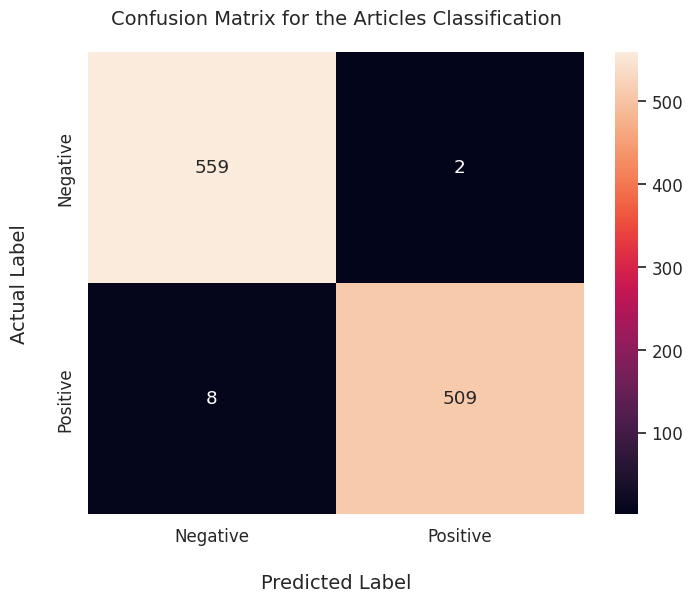

0.9907235621521335

In [10]:
y_pred = predicted_lr > .5
cfm = confusion_matrix(y_true=test_y, y_pred=y_pred )
plot_confusion_matrix(cfm)
accuracy_score(y_pred=y_pred, y_true=test_y)

# Classification of the rest of the data

In [11]:
load_model, corpus

(False, 'wpolityce')

In [12]:
if load_model:
    lr = load("models/lr.joblib")
    selector = load("models/selector.joblib")
    scaler = load("models/scaler.joblib")
    vectorizer = load("models/tfidf.joblib")
 
if corpus == "rzepa":
    df_rest = pd.read_csv(drive_path / corpus / "results.csv", index_col = ['id', 'source'], parse_dates=['date'])
    df_rest = df_rest[~df_rest.index.isin(df_5.index)]
else: 
    df_rest = pd.read_csv(drive_path / corpus / "results.csv", index_col = ['id', 'source'], parse_dates=['date'])

len(df_rest)

6

In [13]:
def chunk_it_predictions(data, size):
    chunks = ceil(len(data) / size)
    for i in tqdm(range(chunks)):
        chunk = df_rest.iloc[i * size : (i+1) * size]
        chunk = preprocess(chunk, STOPWORDS, corpus)
        meta_rest = scaler.transform(chunk[METAFEATURES])
        rest_text = vectorize(chunk['clean_text'], vectorizer, selector)
        rest_ngram_x =  np.concatenate([rest_text, meta_rest], axis=1)
        predicted_lr = lr.predict_proba(rest_ngram_x)[:, 1]
        yield predicted_lr

with pd.option_context('mode.chained_assignment', None):
    proba = np.concatenate([x for x in chunk_it_predictions(df_rest, 500)])

df_rest['proba'] = proba
df_rest.to_csv(drive_path / corpus /  f"results.csv")

100%|██████████| 1/1 [00:00<00:00,  6.56it/s]


# Results

<Axes: xlabel='proba', ylabel='Count'>

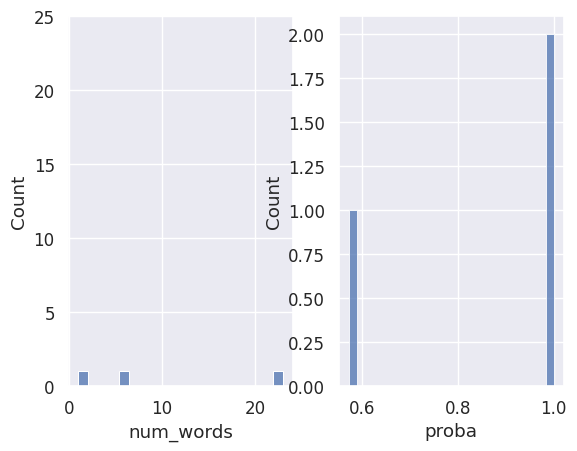

In [14]:
df_rest = pd.read_csv(drive_path / corpus / f"results.csv", index_col= ['id','source'])
df_rest = df_rest[~df_rest.duplicated()]
plt.subplot(1, 2 ,1)
sns.histplot(df_rest[df_rest['proba'] > 0.5]['num_words'], bins = 20)
plt.ylim(0, 25)
plt.subplot(1, 2 ,2)
sns.histplot(df_rest[df_rest['proba'] > 0.5]['proba'], bins = 25)

In [15]:
df_rest['rank'] = 0
df_rest.loc[(df_rest['proba']>0.8) & (df_rest['ngram_sum_squared_to_total'] > 1), 'rank'] = 1
df_rest.loc[(df_rest['proba']>0.8) & (df_rest['ngram_sum_squared_to_total'] <  1), 'rank'] = 2
df_rest.loc[(df_rest['proba'].between(0.5, 0.8)) & (df_rest['ngram_sum_squared_to_total'] > 0.5), 'rank'] = 3
df_rest.loc[(df_rest['proba'].between(0.5, 0.8)) & (df_rest['ngram_sum_squared_to_total'] < 0.5), 'rank'] = 4
#df_rare_words = df_rest[(df_rest['proba'] >  0.7) & (df_rest['num_words'] <= 2)].copy()
len(df_rest[df_rest['proba'] > 0.5])

3

In [16]:
df_rest.loc[df_rest['rank'] != 0, 'label'] = 1
df_eco['rank'] = 1
try:
    df_eco.drop(columns=['translated'], inplace=True)
except:
    print("Droped already")
    
df_rest = df_rest[df_eco.columns.values]
df_final = pd.concat([df_rest[df_rest['rank'] != 0], df_eco])
df_final['rank'].value_counts()

Droped already


1    268
2      2
4      1
Name: rank, dtype: int64

In [17]:
df_final.reset_index().source.value_counts()

wPolityce    271
Name: source, dtype: int64

In [18]:
df_final.to_csv(drive_path / corpus / "eco_all.csv")

In [19]:
df_final.columns

Index(['page', 'title', 'text', 'author', 'date', 'magazine_nr', 'clean_text',
       'clean_title', 'vectorized', 'proba', 'words', 'num_words', 'ngram_sum',
       'ngram_sum_to_total', 'ngram_sum_squared_to_total',
       'ngram_weak__ngrams', 'label', 'rank'],
      dtype='object')

# Saving Model

In [ ]:

models_path = Path("models/")
dump(lr, models_path /'lr.joblib')
dump(vectorizer, models_path / 'tfidf.joblib')
dump(selector, models_path / 'selector.joblib')
dump(scaler, models_path / 'scaler.joblib')

# Crossvalidation 
### to be implemented

In [ ]:
def cross_mistake_validate_model(model, data_all, df_no_translated):
    kFold = KFold(n_splits=5, shuffle=True)
    miss_list = []
    for train_index, val_index in kFold.split(df):
	
        train_data = data_all.iloc[train_index]
        test_data = data_all.iloc[val_index]
        
        train_x = train_data.drop(columns=['class'])
        train_y = train_data['class']

        test_x = test_data.drop(columns=['class'])
        test_y = test_data['class']

        test_x = test_x[~test_x.index.isin(train_x.index)]  # Avoiding data leakage from translated documents
        test_y = test_y[~test_y.index.isin(train_y.index)]


        text_train, text_test = ngram_vectorize(train_x['clean_text_title'], train_y, test_x['clean_text_title'],return_models=False)

        train_encode = enc.fit_transform(train_data[['author', 'department', 'year']]).toarray()
        test_encode = enc.transform(test_data[['author', 'department', 'year']]).toarray()

        train_ngram_x  = np.concatenate([train_encode, text_train], axis=1)
        test_ngram_x  = np.concatenate([test_encode, text_test], axis=1)

        model.fit(train_ngram_x,train_y)
        preds = model.predict(test_ngram_x)
        y_pred = preds > 0.6
        print(accuracy_score(y_pred=y_pred, y_true=test_y))
        result_df = pd.DataFrame({'id': test_y.index.values, 'class': test_y.values})
        result_df['predict'] = y_pred.astype(int)
        result_df['prob'] = preds

        miss_df = result_df[result_df['predict'] != result_df['class']]
        miss_list.append(pd.merge(miss_df, df_no_translated, how='inner', on='id'))

    return pd.concat(miss_list)

# Hyperparameter tuning 
### To be implemented

In [ ]:
import optuna

In [ ]:
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

        
def cross_validate_model(model, data_final, data_prep):
    kFold = KFold(n_splits=5, shuffle=True)
    acc_list = []
    for train_index, val_index in tqdm(kFold.split(df)):   
        train_id = df.iloc[train_index].index
        val_id = df.iloc[val_index].index
        train_data = data_final.loc[train_id]
        test_data = data_final.loc[val_id]
        train_x, train_y, val_x, val_y = data_prep(train_data, test_data)
        model.fit(train_x,train_y)
        preds = model.predict(val_x)
        preds = preds > 0.5
        acc = accuracy_score(val_y, preds)
        acc_list.append(acc)
    return sum(acc_list)/len(acc_list)

In [ ]:
def objective_mnb(trial,data, data_prep):
    
    train_data, test_data = train_test_split(data, test_size=0.3)

    train_x, train_y, test_x, test_y = data_prep(train_data, test_data)
        

    params = {
     'var_smoothing': trial.suggest_float('var_smoothing', 1e-9,100, log='True')
    }       

    #model = GaussianNB(**params)
    #model.fit(train_x,train_y)
    #trial.set_user_attr(key="best_model", value=model)
#
    #preds = model.predict(test_x)
    #preds = preds > 0.5
    


In [ ]:
study_mnb = optuna.create_study(direction='maximize')
study_mnb.optimize(objective_mnb, n_trials=15, callbacks=[callback])
print('Number of finished trials:', len(study_mnb.trials))
print('Best trial:', study_mnb.best_trial.params)